<a href="https://colab.research.google.com/github/viswambhar-yasa/Where_r_Bees/blob/main/AMGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F

In [50]:
## couldnot make multiple output (backward is causing an error)
class DCGAN(nn.Module):
    def __init__(self, z_size, output_size, n_classes, n_output_channels=1):
        super(DCGAN, self).__init__()
        self.output_size=output_size
        self.n_classes=n_classes
        self.Gen = nn.Sequential(
            nn.ConvTranspose2d(in_channels=z_size, out_channels=output_size*16,
                               kernel_size=4, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(output_size*16),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(in_channels=output_size*16, out_channels=output_size*8,
                               kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(output_size*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=output_size*8, out_channels=output_size*4,
                               kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(output_size*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=output_size*4, out_channels=output_size*2,
                               kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(in_channels=output_size*2, out_channels=output_size,
                               kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(output_size),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=output_size, out_channels=n_output_channels,
                               kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            )
        
        self.Dis = nn.Sequential(
            nn.Conv2d(in_channels=n_output_channels, out_channels=output_size,
                      kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=output_size, out_channels=output_size*2,
                      kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(output_size*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=output_size*2, out_channels=output_size*4,
                      kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(output_size*4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=output_size*4, out_channels=output_size*8,
                      kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(output_size*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=output_size*8, out_channels=output_size*16,
                      kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(output_size*16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=output_size*16, out_channels=1,
                        kernel_size=4, stride=1, padding=1, bias=False),
            nn.Sigmoid())

    def forward(self):
      return [self.Gen(),self.Dis()]


In [56]:
class Generator(nn.Module):
    def __init__(self, z_size, output_size, n_classes, n_output_channels=1):
        super(Generator, self).__init__()
        self.output_size=output_size
        self.n_classes=n_classes
        self.Gen = nn.Sequential(
            nn.ConvTranspose2d(in_channels=z_size, out_channels=output_size*16,
                               kernel_size=4, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(output_size*16),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(in_channels=output_size*16, out_channels=output_size*8,
                               kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(output_size*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=output_size*8, out_channels=output_size*4,
                               kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(output_size*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=output_size*4, out_channels=output_size*2,
                               kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(in_channels=output_size*2, out_channels=output_size,
                               kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(output_size),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=output_size, out_channels=n_output_channels,
                               kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            )
    def forward(self,x):
      return self.Gen(x)

In [107]:
class Discrimator(nn.Module):
    def __init__(self, z_size, output_size, n_classes, n_output_channels=1):
        super(Discrimator, self).__init__()
        self.output_size=output_size
        self.n_classes=n_classes
        self.Dis = nn.Sequential(
            nn.Conv2d(in_channels=n_output_channels, out_channels=output_size,
                      kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=output_size, out_channels=output_size*2,
                      kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(output_size*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=output_size*2, out_channels=output_size*4,
                      kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(output_size*4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=output_size*4, out_channels=output_size*8,
                      kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(output_size*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=output_size*8, out_channels=output_size*16,
                      kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(output_size*16),
            nn.LeakyReLU(0.2, inplace=True)
            )
        self.final_conv1=nn.Conv2d(in_channels=self.output_size*16, out_channels=self.n_classes,
                        kernel_size=4, stride=1, padding=1, bias=False)
        self.final_conv2=nn.Conv2d(in_channels=self.output_size*16, out_channels=1,
                        kernel_size=4, stride=1, padding=1, bias=False)
        self.softmax=nn.Softmax(dim=1)
        self.sigmoid=nn.Sigmoid()
    def forward(self,x):
      output1 = self.softmax(self.final_conv1(self.Dis(x)))
      output2 = self.sigmoid(self.final_conv2(self.Dis(x)))
        # Output layer with softmax activation
      return output1,output2

In [108]:

def weight_initialization(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [109]:

print('Pytorch Version', torch.__version__)
print('Is GPU available:',torch.cuda.is_available())
if torch.cuda.is_available():
    print('Number of GPUs',torch.cuda.device_count())

ngpu = torch.cuda.device_count()
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

z_vector_size=128
output_image_size=64
n_classes= 10 ## number of labels
Discrimator_net = Discrimator(z_vector_size, output_image_size,
                  n_classes).to(device)
Generator_net = Generator(z_vector_size, output_image_size,
                  n_classes).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(Generator_net, list(range(ngpu)))
    netD = nn.DataParallel(Discrimator_net, list(range(ngpu)))
else:
    netG = Generator_net
    netD = Discrimator_net
netG.apply(weight_initialization)
netD.apply(weight_initialization)
print('Model building completed')

Pytorch Version 1.12.0+cu113
Is GPU available: True
Number of GPUs 1
Model building completed


In [110]:
from torchvision import models
from torchsummary import summary
summary(netG,(128,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 1024, 2, 2]       2,097,152
       BatchNorm2d-2           [-1, 1024, 2, 2]           2,048
              ReLU-3           [-1, 1024, 2, 2]               0
   ConvTranspose2d-4            [-1, 512, 4, 4]       8,388,608
       BatchNorm2d-5            [-1, 512, 4, 4]           1,024
              ReLU-6            [-1, 512, 4, 4]               0
   ConvTranspose2d-7            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-8            [-1, 256, 8, 8]             512
              ReLU-9            [-1, 256, 8, 8]               0
  ConvTranspose2d-10          [-1, 128, 16, 16]         524,288
      BatchNorm2d-11          [-1, 128, 16, 16]             256
             ReLU-12          [-1, 128, 16, 16]               0
  ConvTranspose2d-13           [-1, 64, 32, 32]         131,072
      BatchNorm2d-14           [-1, 64,

In [111]:
summary(netD,(1,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,024
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12           [-1, 1024, 2, 2]       8,388,608
      BatchNorm2d-13           [-1, 1024, 2, 2]           2,048
        LeakyReLU-14           [-1, 102

In [112]:
criterion = nn.BCELoss()
criterion2=nn.CrossEntropyLoss()
# Learning rate for optimizers
lr = 0.0001

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [113]:
workers = 2

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor()
    ])
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
    ])
)


# Create the dataloader
dataloader = torch.utils.data.DataLoader(training_data, batch_size=32,
                                         shuffle=True, num_workers=workers)

In [114]:
num_epochs=50
max_steps=5

In [115]:
dloss=[]
gloss=[]
for epoch in range(num_epochs):
  for steps,data in enumerate(dataloader,0):
    if steps<max_steps:

      # discrimination training
      optimizerD.zero_grad()
      input_data,label=data[0].to(device),data[1].to(device)
      batch_size=input_data.size(0)
      real_label = torch.full((batch_size,), 1., dtype=torch.float, device=device)
      
      # training on real data 
      realD_output= netD(input_data)
      real_output_labels,real_output = realD_output[0].squeeze(),realD_output[1].squeeze()
      # loss from real labels   
      errD_real = criterion(real_output, real_label)
      # auxillary classifier 
      errD_label=criterion2(real_output_labels,label)
      (errD_real+errD_label).backward(retain_graph=True)
      D_x0 = real_output.mean().item()

      # input latent vectors to generate fake image 
      noise = torch.randn(batch_size,z_vector_size , 1, 1, device=device)
        # Generate fake image batch with Generator
      fake_label=torch.full((batch_size,), 0., dtype=torch.float, device=device)
      gen_data=netG(noise)
      # discrimation training on fake images
      fakeD_output= netD(gen_data)
      fake_output_labels,fake_output = fakeD_output[0].squeeze(),fakeD_output[1].squeeze()
      # loss for fake image
      errD_fake= criterion(fake_output, fake_label)
      errD_fake.backward(retain_graph=True)
      D_x1=fake_output.mean().item()
      total_Dloss=errD_real+errD_fake+errD_label
      optimizerD.step()

      optimizerG.zero_grad()
      fakeD_output_gen= netD(gen_data)
      fake_output_labels_gen,fake_output_gen = fakeD_output_gen[0].squeeze(),fakeD_output_gen[1].squeeze()
      errG_label= criterion(fake_output_gen, real_label)
      # Calculate gradients for G
      errG_label.backward(retain_graph=True)
      D_G_z2 = fake_output_gen.mean().item()
      # Update G
      optimizerG.step()
    else:
      break
  dloss.append(total_Dloss.item())
  gloss.append(errG_label.item())
  print('Epoch: ',epoch,'   critic Loss: ',total_Dloss.item() ,'  Generator Loss: ',errG_label.item())

Epoch:  0    critic Loss:  2.536386013031006   Generator Loss:  5.3328094482421875
Epoch:  1    critic Loss:  2.2984702587127686   Generator Loss:  5.542654514312744
Epoch:  2    critic Loss:  2.101864814758301   Generator Loss:  6.231584548950195
Epoch:  3    critic Loss:  2.0155465602874756   Generator Loss:  5.397793769836426
Epoch:  4    critic Loss:  1.732766032218933   Generator Loss:  11.664587020874023
Epoch:  5    critic Loss:  2.0726449489593506   Generator Loss:  5.381270408630371
Epoch:  6    critic Loss:  1.9616984128952026   Generator Loss:  15.777040481567383
Epoch:  7    critic Loss:  1.8868483304977417   Generator Loss:  13.396646499633789
Epoch:  8    critic Loss:  1.962577223777771   Generator Loss:  7.223982810974121
Epoch:  9    critic Loss:  1.8980164527893066   Generator Loss:  6.700555324554443
Epoch:  10    critic Loss:  1.7994482517242432   Generator Loss:  8.027304649353027
Epoch:  11    critic Loss:  1.9139909744262695   Generator Loss:  3.9249606132507324
E

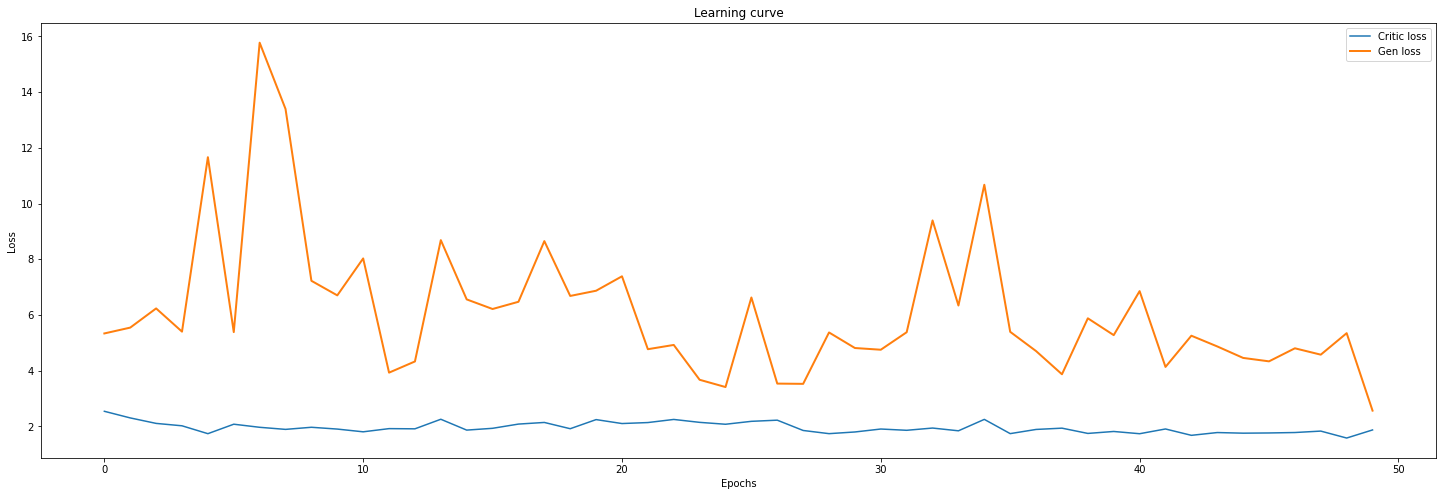

In [124]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(25,8))
plt.plot(np.array(dloss),label='Critic loss')
plt.plot(np.array(gloss),label='Gen loss',linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning curve')
plt.legend()